In [ ]:
import os, torch, numpy as np
from scipy.spatial import KDTree
from torch_geometric.data import Data

def compute_normals(pts, k=8):
    """PCA法向量估计：输出 N x 3"""
    tree = KDTree(pts)
    _, indices = tree.query(pts, k=k)
    normals = []
    for i, neighbors in enumerate(indices):
        neighborhood = pts[neighbors] - np.mean(pts[neighbors], axis=0)
        _, _, vh = np.linalg.svd(neighborhood)
        normal = vh[2, :] # 最小特征值对应方向
        if np.dot(normal, pts[i]) < 0: normal = -normal
        normals.append(normal)
    return np.array(normals)

def process_intra_data(root_path):
    dataset = []
    tasks = [('fileSplit/cls/ann_clsSplit_0.txt', 1), ('fileSplit/cls/negSplit_0.txt', 0)]
    
    for split_f, label in tasks:
        path = os.path.join(root_path, split_f)
        if not os.path.exists(path): continue
        with open(path, 'r') as f:
            for line in f:
                p_path = os.path.join(root_path, "IntrA", line.strip())
                if os.path.exists(p_path):
                    # 加载与标准化
                    pts = np.array([ [float(x) for x in l.split()][:3] for l in open(p_path) if len(l.split())>=3 ])
                    pts -= np.mean(pts, axis=0)
                    pts /= (np.max(np.abs(pts)) + 1e-6)
                    
                    # 特征工程：坐标(3) + 法向量(3)
                    norms = compute_normals(pts)
                    x = torch.tensor(np.hstack([pts, norms]), dtype=torch.float)
                    
                    # 构图
                    tree = KDTree(pts)
                    _, idx = tree.query(pts, k=6)
                    edge_index = torch.tensor([ [i, n] for i, nbs in enumerate(idx) for n in nbs ], dtype=torch.long).t().contiguous()
                    
                    dataset.append(Data(x=x, pos=torch.tensor(pts, dtype=torch.float), edge_index=edge_index, y=torch.tensor([label], dtype=torch.float)))
    
    print(f"✅ 预处理完成：共 {len(dataset)} 样本，特征维度 {dataset[0].x.shape[1]}")
    return dataset

# 执行并存储到全局变量
processed_data = process_intra_data(".")

✅ 预处理完成：共 404 样本，特征维度 6


In [2]:
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
import torch.nn.functional as F

class AneurysmNet(torch.nn.Module):
    def __init__(self, in_channels=6): # 接收标准化的 6 维输入
        super().__init__()
        self.conv1 = GATConv(in_channels, 16, heads=2)
        self.conv2 = GATConv(32, 16, heads=1)
        # 双路池化：同时关注平均形态与极端特征
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(16 * 2, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        
        # 拼接 Mean 和 Max 池化以增强特征表达
        x_pool = torch.cat([global_mean_pool(x, batch), global_max_pool(x, batch)], dim=1)
        return self.fc(x_pool)

print("✅ 模型定义完成。")

✅ 模型定义完成。


In [5]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import torch

# 1. 获取所有样本的标签用于分层参考
all_labels = [data.y.item() for data in processed_data]

# 2. 执行分层抽样划分 (Stratified Split)
# train_test_split 会根据 stratify 参数自动保持 y 的比例一致
train_indices, test_indices = train_test_split(
    range(len(processed_data)), 
    test_size=0.2, 
    random_state=42, 
    stratify=all_labels  # 核心参数：按标签比例分层
)

train_set = [processed_data[i] for i in train_indices]
test_set = [processed_data[i] for i in test_indices]

# 3. 验证分层结果 (反馈环节)
def check_ratio(dataset, name):
    labels = [d.y.item() for d in dataset]
    pos = labels.count(1)
    neg = labels.count(0)
    print(f"📊 {name}比例: 破裂(1)={pos}, 稳定(0)={neg}, 占比={pos/(pos+neg):.2%}")

check_ratio(train_set, "训练集")
check_ratio(test_set, "测试集")

# 4. 标准 DataLoader 定义
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1)

# 5. 带有正样本加权的 Loss 定义
model = AneurysmNet(in_channels=6).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 计算正样本权重：N_negative / N_positive
pos_weight = all_labels.count(0) / all_labels.count(1) 
print(f"⚖️ Loss 权重设定: {pos_weight:.2f} (错失破裂样本的惩罚倍数)")

def train_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        target = batch.y.view(-1, 1)
        # 加权二元交叉熵损失
        loss = -(pos_weight * target * torch.log(out + 1e-7) + (1 - target) * torch.log(1 - out + 1e-7)).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 训练循环
for epoch in range(20):
    loss = train_epoch()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {loss:.4f}")

📊 训练集比例: 破裂(1)=53, 稳定(0)=270, 占比=16.41%
📊 测试集比例: 破裂(1)=13, 稳定(0)=68, 占比=16.05%
⚖️ Loss 权重设定: 5.12 (错失破裂样本的惩罚倍数)
Epoch 05 | Loss: 1.1311
Epoch 10 | Loss: 0.9584
Epoch 15 | Loss: 0.8432
Epoch 20 | Loss: 0.7708


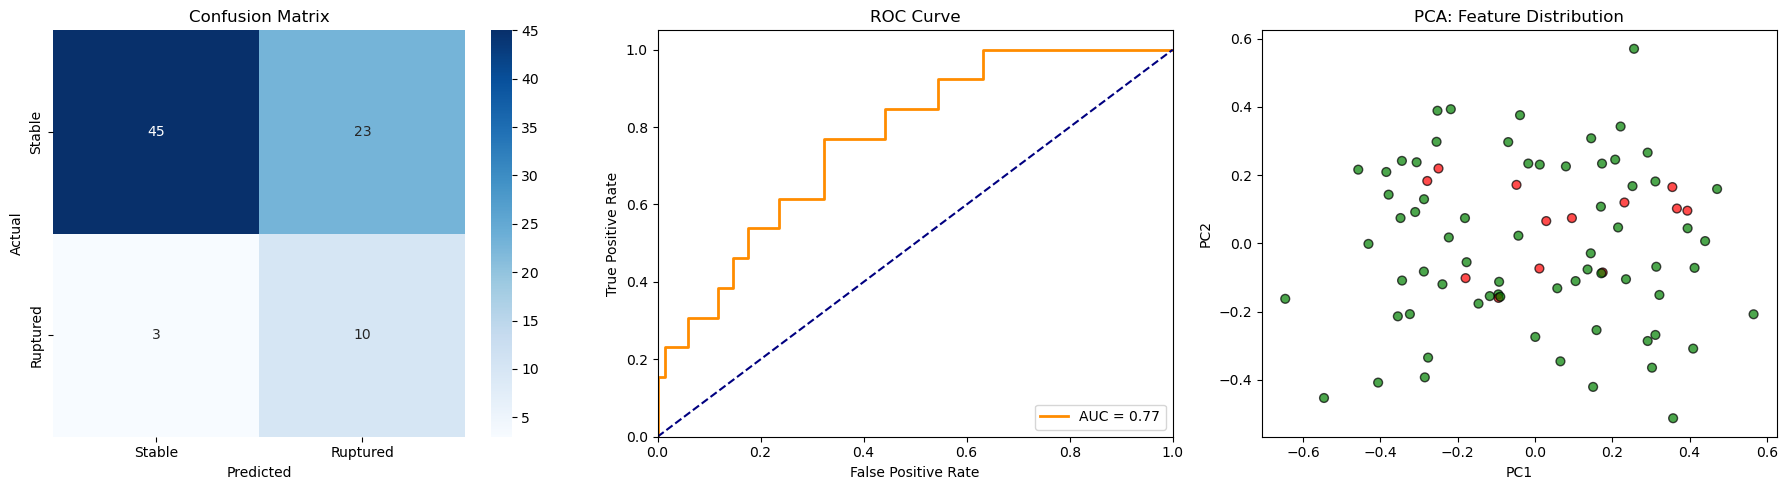

📊 分析报告:
测试集样本总数: 81
模型预测破裂数: 33
实际破裂总数: 13.0


In [6]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

def robust_analysis(model, test_dataset):
    model.eval()
    y_true, y_probs, y_preds = [], [], []
    features_list = []
    
    # 1. 收集测试集数据
    with torch.no_grad():
        for data in test_dataset:
            y_true.append(data.y.item())
            
            # 获取预测概率
            prob = model(data.to('cpu')).item()
            y_probs.append(prob)
            y_preds.append(1 if prob > 0.5 else 0)
            
            # 提取全局特征用于 PCA 可视化
            # 模拟模型最后输出前的特征向量
            x, edge_index = data.x, data.edge_index
            h = F.elu(model.conv1(x, edge_index))
            h = F.elu(model.conv2(h, edge_index))
            # 压缩空间维度得到样本特征指纹
            feat = torch.mean(h, dim=0).numpy()
            features_list.append(feat)

    plt.figure(figsize=(18, 5))

    # --- 功能 A: 混淆矩阵 (查看漏诊/误诊) ---
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Stable', 'Ruptured'], yticklabels=['Stable', 'Ruptured'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # --- 功能 B: ROC 曲线 (评估模型整体判别力) ---
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # --- 功能 C: PCA 特征投影 (安全稳定的聚类查看) ---
    plt.subplot(1, 3, 3)
    pca = PCA(n_components=2)
    pca_vis = pca.fit_transform(np.array(features_list))
    # 红色代表破裂样本，绿色代表稳定样本
    colors = ['green' if y == 0 else 'red' for y in y_true]
    plt.scatter(pca_vis[:, 0], pca_vis[:, 1], c=colors, alpha=0.7, edgecolors='k', s=40)
    plt.title("PCA: Feature Distribution")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    
    plt.tight_layout()
    plt.show()

    # 打印简要报告
    print(f"📊 分析报告:")
    print(f"测试集样本总数: {len(y_true)}")
    print(f"模型预测破裂数: {sum(y_preds)}")
    print(f"实际破裂总数: {sum(y_true)}")

# 执行分析
robust_analysis(model, test_set)